## 数据模块又可以细分为 4 个部分：
1. 数据收集：样本和标签。
2. 数据划分：训练集、验证集和测试集
3. 数据读取：对应于PyTorch 的 DataLoader。其中 DataLoader 包括 Sampler 和 DataSet。Sampler 的功能是生成索引，DataSet 是根据生成的索引读取样本以及标签。
4. 数据预处理：对应于 PyTorch 的 transforms

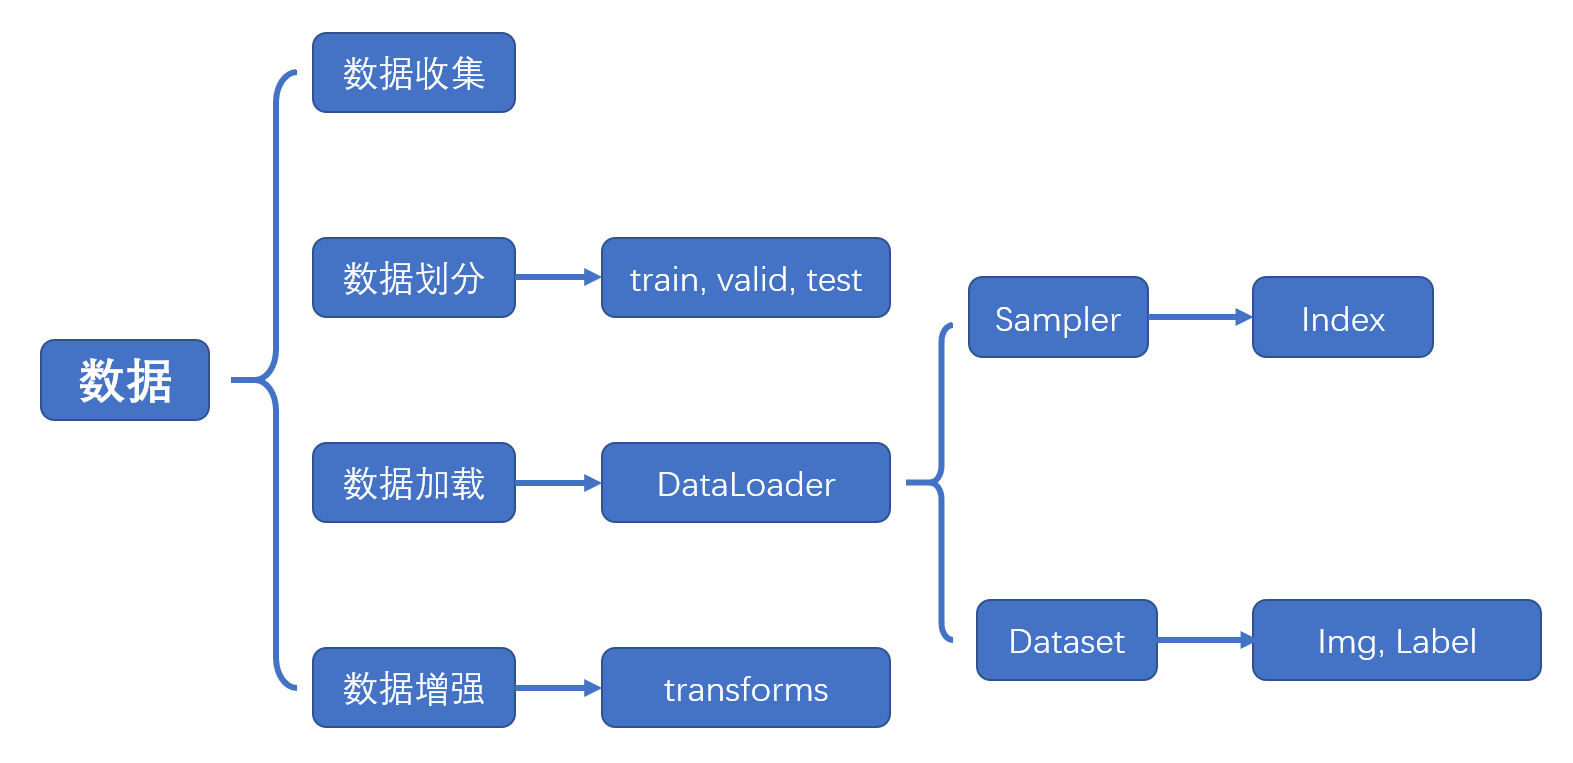

## torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, sampler=None, batch_sampler=None, num_workers=0, collate_fn=None, pin_memory=False, drop_last=False, timeout=0, worker_init_fn=None, multiprocessing_context=None)
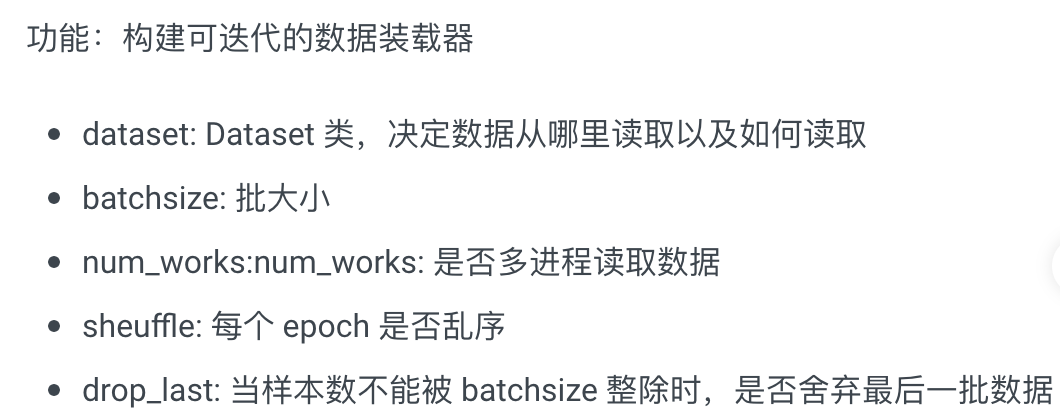

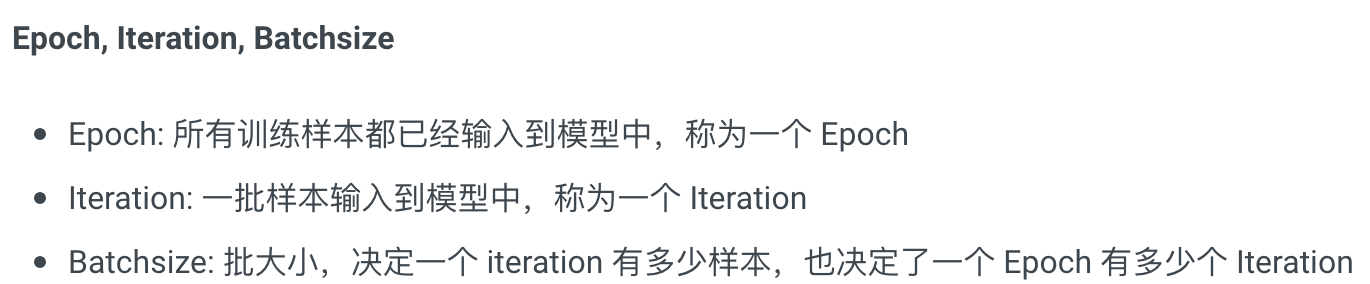

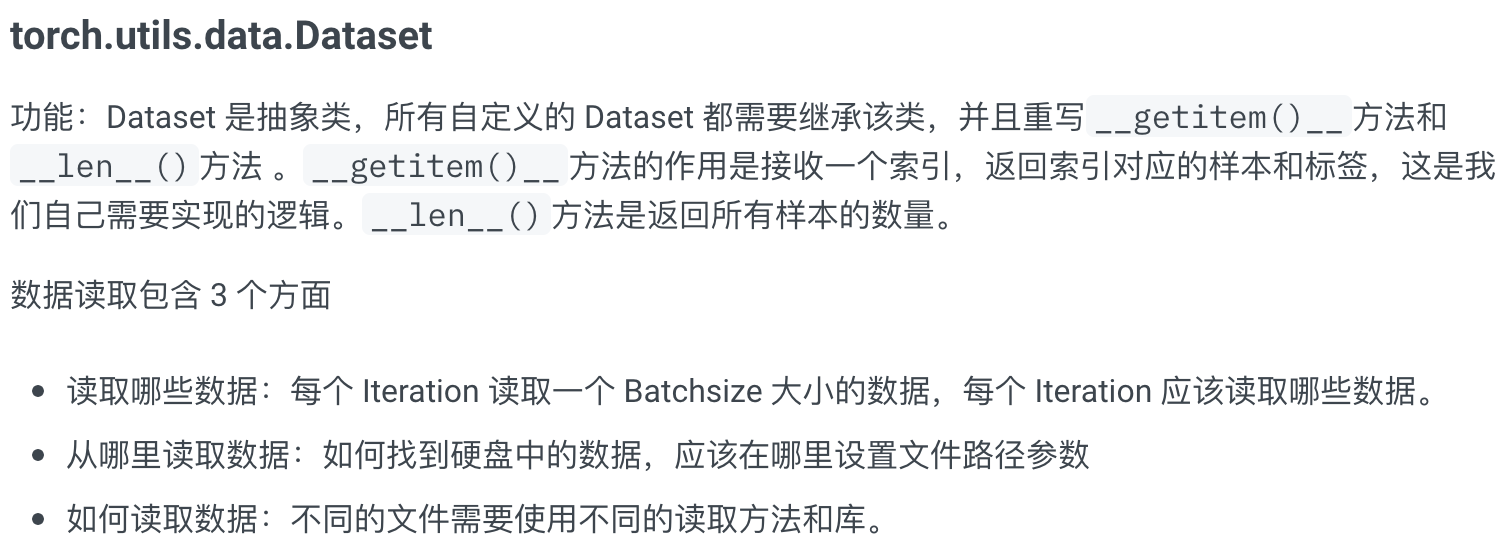

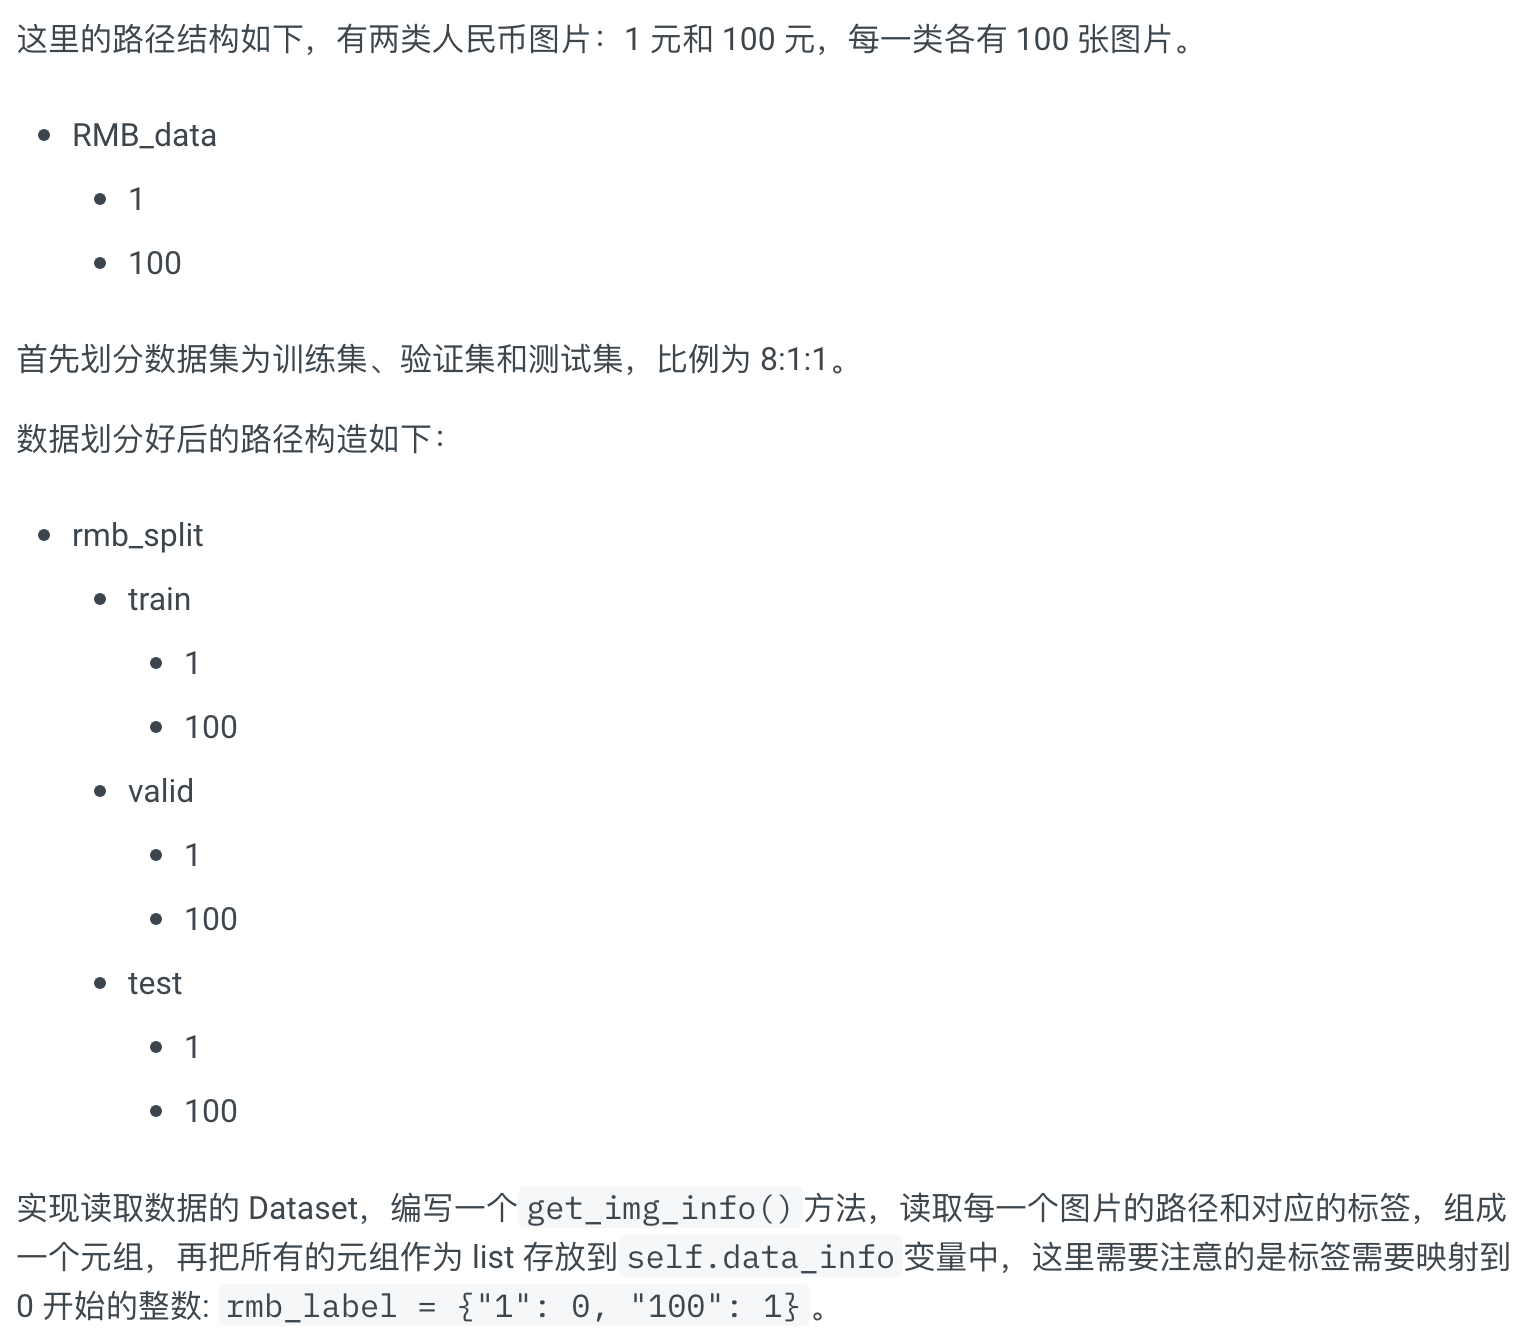

In [ ]:
import os

rmb_label = {"1": 0, "100": 1}
@staticmethod
def get_img_info(data_dir):
    data_info = list()
    # data_dir 是训练集、验证集或者测试集的路径
    for root, dirs, _ in os.walk(data_dir):
        # 遍历类别
        # dirs ['1', '100']
        for sub_dir in dirs:
            # 文件列表
            img_names = os.listdir(os.path.join(root, sub_dir))
            # 取出 jpg 结尾的文件
            img_names = list(filter(lambda x: x.endswith('.jpg'), img_names))
            # 遍历图片
            for i in range(len(img_names)):
                img_name = img_names[i]
                # 图片的绝对路径
                path_img = os.path.join(root, sub_dir, img_name)
                # 标签，这里需要映射为 0、1 两个类别
                label = rmb_label[sub_dir]
                # 保存在 data_info 变量中
                data_info.append((path_img, int(label)))
    return data_info

然后在Dataset 的初始化函数中调用get_img_info()方法。

In [ ]:
def __init__(self, data_dir, transform=None):
    """
    rmb面额分类任务的Dataset
    :param data_dir: str, 数据集所在路径
    :param transform: torch.transform，数据预处理
    """
    # data_info存储所有图片路径和标签，在DataLoader中通过index读取样本
    self.data_info = self.get_img_info(data_dir)
    self.transform = transform

然后在__getitem__()方法中根据index 读取self.data_info中路径对应的数据，并在这里做 transform 操作，返回的是样本和标签。

In [ ]:
def __getitem__(self, index):
    # 通过 index 读取样本
    path_img, label = self.data_info[index]
    # 注意这里需要 convert('RGB')
    img = Image.open(path_img).convert('RGB')     # 0~255
    if self.transform is not None:
        img = self.transform(img)   # 在这里做transform，转为tensor等等
    # 返回是样本和标签
    return img, label

在__len__()方法中返回self.data_info的长度，即为所有样本的数量。

In [ ]:
# 返回所有样本的数量
def __len__(self):
    return len(self.data_info)

## 5步构建模型

第 1 步设置数据。首先定义训练集、验证集、测试集的路径，定义训练集和测试集的transforms。然后构建训练集和验证集的RMBDataset对象，把对应的路径和transforms传进去。再构建DataLoder，设置 batch_size，其中训练集设置shuffle=True，表示每个 Epoch 都打乱样本。

In [ ]:
# 构建MyDataset实例train_data = RMBDataset(data_dir=train_dir, transform=train_transform)valid_data = RMBDataset(data_dir=valid_dir, transform=valid_transform)

# 构建DataLoder
# 其中训练集设置 shuffle=True，表示每个 Epoch 都打乱样本
train_loader = DataLoader(dataset=train_data, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)
valid_loader = DataLoader(dataset=valid_data, 
                          batch_size=BATCH_SIZE)

第 2 步构建模型，这里采用经典的 Lenet 图片分类网络。

In [ ]:
net = LeNet(classes=2)
net.initialize_weights()

第 3 步设置损失函数，这里使用交叉熵损失函数。

In [ ]:
criterion = nn.CrossEntropyLoss()

第 4 步设置优化器。这里采用 SGD 优化器。

In [ ]:
optimizer = optim.SGD(net.parameters(), lr=LR,
                      momentum=0.9)                        # 选择优化器
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=10, gamma=0.1)     # 设置学习率下降策略

第 5 步迭代训练模型，在每一个 epoch 里面，需要遍历 train_loader 取出数据，每次取得数据是一个 batchsize 大小。
这里又分为 4 步。
- 第 1 步进行前向传播
- 第 2 步进行反向传播求导
- 第 3 步使用optimizer更新权重
- 第 4 步统计训练情况。  
每一个 epoch 完成时都需要使用scheduler更新学习率，和计算验证集的准确率、loss。

In [ ]:
for epoch in range(MAX_EPOCH):

    loss_mean = 0.
    correct = 0.
    total = 0.

    net.train()
    # 遍历 train_loader 取数据
    for i, data in enumerate(train_loader):

        # forward
        inputs, labels = data
        outputs = net(inputs)

        # backward
        optimizer.zero_grad()
        loss = criterion(outputs, labels)
        loss.backward()

        # update weights
        optimizer.step()

        # 统计分类情况
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).squeeze().sum().numpy()

        # 打印训练信息
        loss_mean += loss.item()
        train_curve.append(loss.item())
        if (i+1) % log_interval == 0:
            loss_mean = loss_mean / log_interval
            print("Training:Epoch[{:0>3}/{:0>3}] Iteration[{:0>3}/{:0>3}] Loss: {:.4f} Acc:{:.2%}".format(
                epoch, MAX_EPOCH, i+1, len(train_loader), loss_mean, correct / total))
            loss_mean = 0.

    scheduler.step()  # 更新学习率
    # 每个 epoch 计算验证集得准确率和loss
    ...
    ...

## 分析dataloader

In [ ]:
from torch.utils.data import DataLoader

# dataloader.py文件中
def _get_iterator(self) -> '_BaseDataLoaderIter':
    if self.num_workers == 0:
        return _SingleProcessDataLoaderIter(self)
    else:
        self.check_worker_number_rationality()
        return _MultiProcessingDataLoaderIter(self)

没有设置多进程，会执行_SingleProcessDataLoaderIter的方法  
在_SingleProcessDataLoaderIter里只有一个方法_next_data()

In [ ]:
def _next_data(self):
    index = self._next_index()  # may raise StopIteration
    data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
    if self._pin_memory:
        data = _utils.pin_memory.pin_memory(data, self._pin_memory_device)
    return data

在该方法中，self._next_index()是获取一个 batchsize 大小的 index 列表

In [ ]:
def _next_index(self):
    return next(self._sampler_iter)  # may raise StopIteration

其中调用的sampler类的__iter__()方法返回 batch_size 大小的随机 index 列表。

In [ ]:
def __iter__(self):
    batch = []
    for idx in self.sampler:
        batch.append(idx)
        if len(batch) == self.batch_size:
            yield batch
            batch = []
    if len(batch) > 0 and not self.drop_last:
        yield batch

然后再返回看 dataloader的_next_data()方法：

In [ ]:
def _next_data(self):
    index = self._next_index()  # may raise StopIteration
    data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
    if self._pin_memory:
        data = _utils.pin_memory.pin_memory(data)
    return data

在第二行中调用了self._dataset_fetcher.fetch(index)获取数据。这里会调用_MapDatasetFetcher中的fetch()函数：

In [ ]:
def fetch(self, possibly_batched_index):
    if self.auto_collation:
        data = [self.dataset[idx] for idx in possibly_batched_index]
    else:
        data = self.dataset[possibly_batched_index]
    return self.collate_fn(data)

这里调用了self.dataset[idx]，这个函数会调用dataset.__getitem__()方法获取具体的数据，所以__getitem__()方法是我们必须实现的。我们拿到的data是一个 list，每个元素是一个 tunple，每个 tunple 包括样本和标签。所以最后要使用self.collate_fn(data)把 data 转换为两个 list，第一个 元素 是样本的batch 形式，形状为 [16, 3, 32, 32] (16 是 batch size，[3, 32, 32] 是图片像素)；第二个元素是标签的 batch 形式，形状为 [16]。

所以在代码中，我们使用inputs, labels = data来接收数据。

PyTorch 数据读取流程图
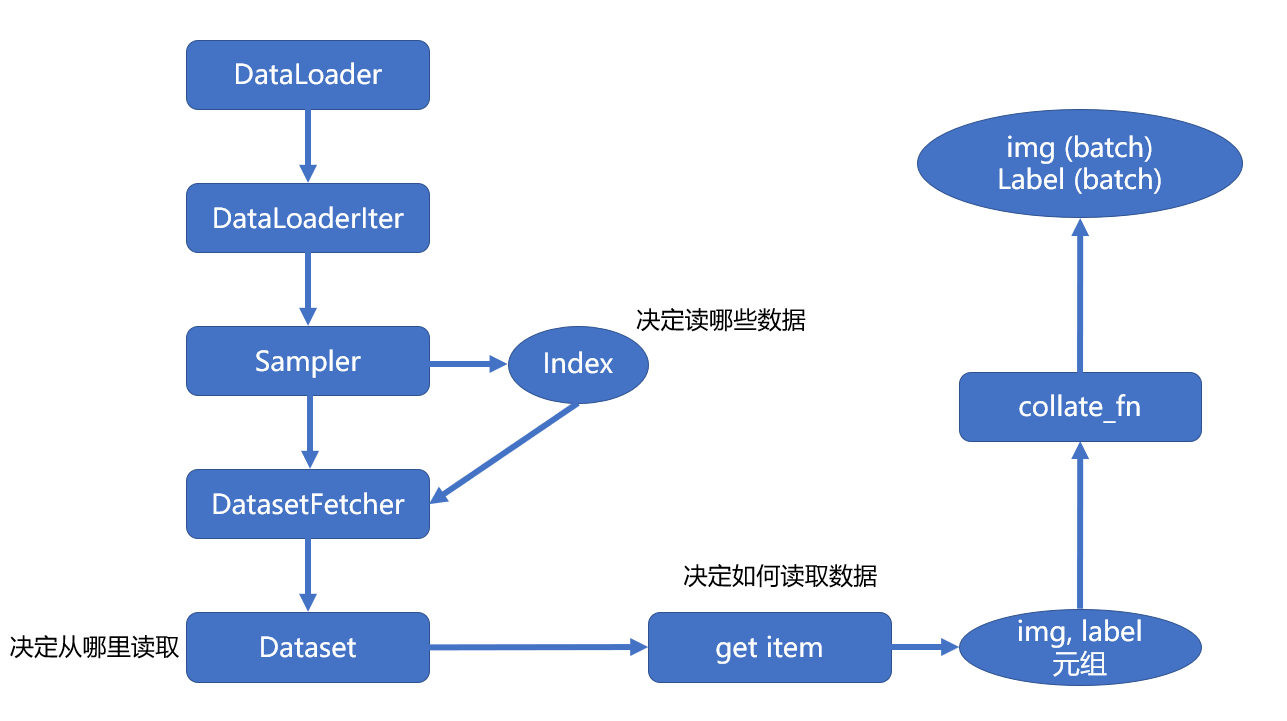

首先在 for 循环中遍历DataLoader，然后根据是否采用多进程，决定使用单进程或者多进程的DataLoaderIter。在DataLoaderIter里调用Sampler生成Index的 list，再调用DatasetFetcher根据index获取数据。在DatasetFetcher里会调用Dataset的__getitem__()方法获取真正的数据。这里获取的数据是一个 list，其中每个元素是 (img, label) 的元组，再使用 collate_fn()函数整理成一个 list，里面包含两个元素，分别是 img 和 label 的tenser。
